### **Setup: Installing and Importing Libraries**

Our main tool for this module is **PyTorch**, the leading deep learning framework. We'll also use `torchvision` for easy access to datasets and `torchinfo` for summarizing our model's architecture.

In [ ]:
%pip install -q torch torchvision torchinfo matplotlib numpy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms as T
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Set up device-agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---

## **Part 1: Preparing the Data - The Fashion MNIST Dataset**

To train our network, we need a dataset. We'll use **Fashion MNIST**, a classic beginner's dataset. It consists of 60,000 training images and 10,000 testing images of 10 different types of clothing (T-shirts, trousers, coats, etc.). It's a great step up from the simpler digit MNIST dataset.

### **1.1 Defining Preprocessing Transforms**

We need to process the images before feeding them to our network. This involves two main steps:
1.  **ToTensor():** Converts the image from a PIL Image format into a PyTorch tensor and scales the pixel values from the `[0, 255]` range to the `[0.0, 1.0]` range.
2.  **Normalize():** Standardizes the pixel values to have a specific mean and standard deviation. This helps the network train faster and more stably. For Fashion MNIST, these values are pre-calculated.

In [ ]:
data_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.2860,), std=(0.3530,)) # Mean and Std for Fashion MNIST
])

### **1.2 Downloading the Dataset and Creating DataLoaders**

`torchvision.datasets` makes it incredibly easy to download standard datasets. We will download the training and testing sets. Then, we'll wrap them in a `DataLoader`, which is a utility that provides batches of data to our model during training, handles shuffling, and can use multiple workers to load data in parallel.

In [ ]:
BATCH_SIZE = 64

# Download training data
train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms
)

# Download test data
test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transforms
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.3MB/s]

Number of training batches: 938
Number of testing batches: 157


### **1.3 Visualizing the Data**

Let's take a look at a few samples to see what our data looks like.

Image batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])


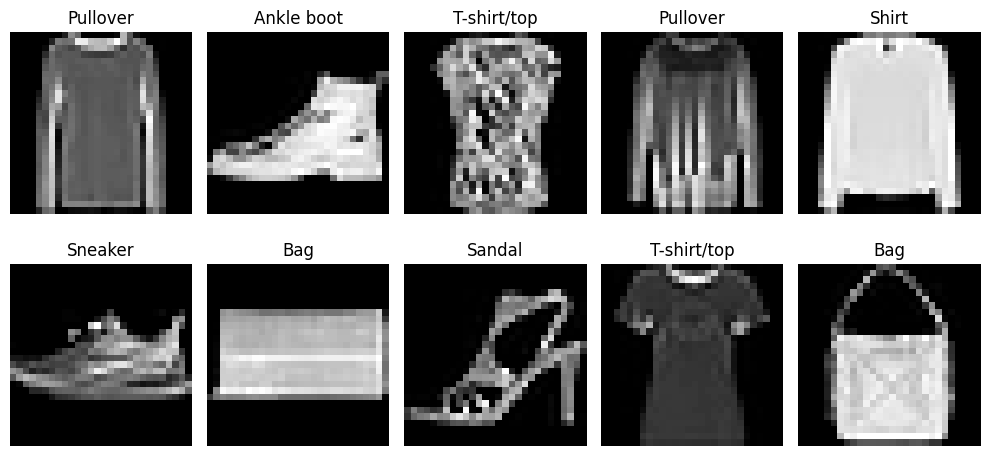

In [ ]:
class_names = train_dataset.classes

def show_images(images, labels, n_rows=2, n_cols=5):
    plt.figure(figsize=(10, 5))
    for i, (image, label) in enumerate(zip(images, labels)):
        if i >= n_rows * n_cols:
            break
        plt.subplot(n_rows, n_cols, i + 1)
        # Squeeze to remove the channel dimension for grayscale
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title(class_names[label])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get a single batch of images
images, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

show_images(images, labels)

---

## **Part 2: Modeling the CNN Architecture**

Now we'll define the structure of our neural network. We will build a simple CNN inspired by the famous **LeNet-5** architecture. It will have two main parts:

1.  **The Feature Extractor (`_body`):** A sequence of Convolutional (`Conv2d`) and Pooling (`MaxPool2d`) layers. This part of the network is responsible for learning the visual features (the learned kernels!).
2.  **The Classifier (`_head`):** A sequence of standard Fully-Connected (`Linear`) layers that takes the extracted features and makes the final classification decision.

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Feature Extractor
        self.feature_extractor = nn.Sequential(
            # 1st Conv Layer: Input 1x28x28 -> Output 6x24x24
            # Note: We'll add padding to keep size 28x28
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            # Pooling Layer: 6x28x28 -> 6x14x14
            nn.MaxPool2d(kernel_size=2),

            # 2nd Conv Layer: 6x14x14 -> 16x10x10
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            # Pooling Layer: 16x10x10 -> 16x5x5
            nn.MaxPool2d(kernel_size=2),
        )

        # Classifier
        self.classifier = nn.Sequential(
            # We need to flatten the 16x5x5 output from the feature extractor
            nn.Linear(in_features=16 * 5 * 5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=num_classes)
        )

    def forward(self, x):
        # Pass through feature extractor
        x = self.feature_extractor(x)
        # Flatten the output for the classifier
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        # Pass through classifier
        logits = self.classifier(x)
        return logits

### **2.1 Model Summary**

Let's instantiate our model and use `torchinfo.summary` to get a nice overview of its architecture, the output shape at each layer, and the total number of parameters. This is a great sanity check.

In [ ]:
model = LeNet5(num_classes=len(class_names)).to(device)

# Print the model summary
summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [64, 10]                  --
├─Sequential: 1-1                        [64, 16, 5, 5]            --
│    └─Conv2d: 2-1                       [64, 6, 28, 28]           156
│    └─ReLU: 2-2                         [64, 6, 28, 28]           --
│    └─MaxPool2d: 2-3                    [64, 6, 14, 14]           --
│    └─Conv2d: 2-4                       [64, 16, 10, 10]          2,416
│    └─ReLU: 2-5                         [64, 16, 10, 10]          --
│    └─MaxPool2d: 2-6                    [64, 16, 5, 5]            --
├─Sequential: 1-2                        [64, 10]                  --
│    └─Linear: 2-7                       [64, 120]                 48,120
│    └─ReLU: 2-8                         [64, 120]                 --
│    └─Linear: 2-9                       [64, 84]                  10,164
│    └─ReLU: 2-10                        [64, 84]                  --
│  

---

## **Part 3: The Training Pipeline**

Now we'll create the functions that will handle the training and evaluation of our model.

### **3.1 The Training Step**

This function will perform one full pass (an **epoch**) over the training data. For each batch, it will:
1.  Make a prediction (forward pass).
2.  Calculate the error (loss).
3.  Calculate the gradients (backward pass).
4.  Update the model's weights (optimizer step).

In [ ]:
def train_step(model, data_loader, loss_fn, optimizer, device):
    model.train() # Set model to training mode
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred_logits = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred_logits)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(data_loader)
    train_acc = train_acc / len(data_loader)
    return train_loss, train_acc

### **3.2 The Testing Step**

This function will evaluate the model on the test dataset. It's similar to the training step but without the backpropagation and weight updates. We're only interested in how well the model is performing.

In [ ]:
def test_step(model, data_loader, loss_fn, device):
    model.eval() # Set model to evaluation mode
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(data_loader)
    test_acc = test_acc / len(data_loader)
    return test_loss, test_acc

### **3.3 The Training Loop**

Finally, we'll create the main training loop that puts everything together. It will:
1.  Define the loss function (`CrossEntropyLoss` for multi-class classification) and the optimizer (`Adam` is a great default).
2.  Loop for a set number of **epochs**.
3.  Call the `train_step` and `test_step` functions for each epoch.
4.  Print out the results so we can watch our model learn!

In [ ]:
from tqdm.auto import tqdm

def train(model, train_loader, test_loader, optimizer, loss_fn, epochs, device):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_loader, loss_fn, device)

        print(f"Epoch: {epoch+1} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} | "
              f"Test Acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [ ]:
NUM_EPOCHS = 5

model = LeNet5(num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

print("Starting training...")
model_results = train(model, train_loader, test_loader, optimizer, loss_fn, NUM_EPOCHS, device)
print("Training complete!")

Starting training...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.4916 | Train Acc: 0.8208 | Test Loss: 0.4138 | Test Acc: 0.8525
Epoch: 2 | Train Loss: 0.3715 | Train Acc: 0.8666 | Test Loss: 0.3884 | Test Acc: 0.8624
Epoch: 3 | Train Loss: 0.3573 | Train Acc: 0.8726 | Test Loss: 0.3669 | Test Acc: 0.8687
Epoch: 4 | Train Loss: 0.3435 | Train Acc: 0.8773 | Test Loss: 0.3792 | Test Acc: 0.8650
Epoch: 5 | Train Loss: 0.3421 | Train Acc: 0.8777 | Test Loss: 0.3626 | Test Acc: 0.8762
Training complete!


In [ ]:
NUM_EPOCHS_LONGER = 20

model_longer = LeNet5(num_classes=len(class_names)).to(device)
loss_fn_longer = nn.CrossEntropyLoss()
optimizer_longer = torch.optim.Adam(params=model_longer.parameters(), lr=0.005)

print(f"Starting longer training for {NUM_EPOCHS_LONGER} epochs...")
model_results_longer = train(model_longer, train_loader, test_loader, optimizer_longer, loss_fn_longer, NUM_EPOCHS_LONGER, device)
print("Longer training complete! Compare the final test accuracy to the 5-epoch run.")

Starting longer training for 20 epochs...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.4873 | Train Acc: 0.8175 | Test Loss: 0.3542 | Test Acc: 0.8669
Epoch: 2 | Train Loss: 0.3322 | Train Acc: 0.8779 | Test Loss: 0.3300 | Test Acc: 0.8840
Epoch: 3 | Train Loss: 0.3029 | Train Acc: 0.8887 | Test Loss: 0.3854 | Test Acc: 0.8777
Epoch: 4 | Train Loss: 0.2872 | Train Acc: 0.8940 | Test Loss: 0.3290 | Test Acc: 0.8867
Epoch: 5 | Train Loss: 0.2740 | Train Acc: 0.8992 | Test Loss: 0.3157 | Test Acc: 0.8844
Epoch: 6 | Train Loss: 0.2627 | Train Acc: 0.9037 | Test Loss: 0.3305 | Test Acc: 0.8808
Epoch: 7 | Train Loss: 0.2594 | Train Acc: 0.9049 | Test Loss: 0.3230 | Test Acc: 0.8874
Epoch: 8 | Train Loss: 0.2497 | Train Acc: 0.9074 | Test Loss: 0.3410 | Test Acc: 0.8821
Epoch: 9 | Train Loss: 0.2398 | Train Acc: 0.9117 | Test Loss: 0.3123 | Test Acc: 0.8941
Epoch: 10 | Train Loss: 0.2356 | Train Acc: 0.9132 | Test Loss: 0.3553 | Test Acc: 0.8852
Epoch: 11 | Train Loss: 0.2356 | Train Acc: 0.9132 | Test Loss: 0.3059 | Test Acc: 0.8996
Epoch: 12 | Train L